Bắt đầu tối ưu hóa mẫu búp sóng cho 16 anten...
Cycle 1/100: Best Error = 2438.9796
Cycle 2/100: Best Error = 2120.8335
Cycle 3/100: Best Error = 2120.8335
Cycle 4/100: Best Error = 2104.1330
Cycle 5/100: Best Error = 2089.4931
Cycle 6/100: Best Error = 2089.4931
Cycle 7/100: Best Error = 2089.4931
Cycle 8/100: Best Error = 2072.7776
Cycle 9/100: Best Error = 2056.3547
Cycle 10/100: Best Error = 1883.1269
Cycle 11/100: Best Error = 1833.4163
Cycle 12/100: Best Error = 1603.1159
Cycle 13/100: Best Error = 1551.2391
Cycle 14/100: Best Error = 1544.1679
Cycle 15/100: Best Error = 1544.1679
Cycle 16/100: Best Error = 1363.9489
Cycle 17/100: Best Error = 1363.9489
Cycle 18/100: Best Error = 1318.2606
Cycle 19/100: Best Error = 1313.3546
Cycle 20/100: Best Error = 1182.3557
Cycle 21/100: Best Error = 1118.4640
Cycle 22/100: Best Error = 1118.4640
Cycle 23/100: Best Error = 1118.4640
Cycle 24/100: Best Error = 1118.4640
Cycle 25/100: Best Error = 1118.4640
Cycle 26/100: Best Error = 956.4805


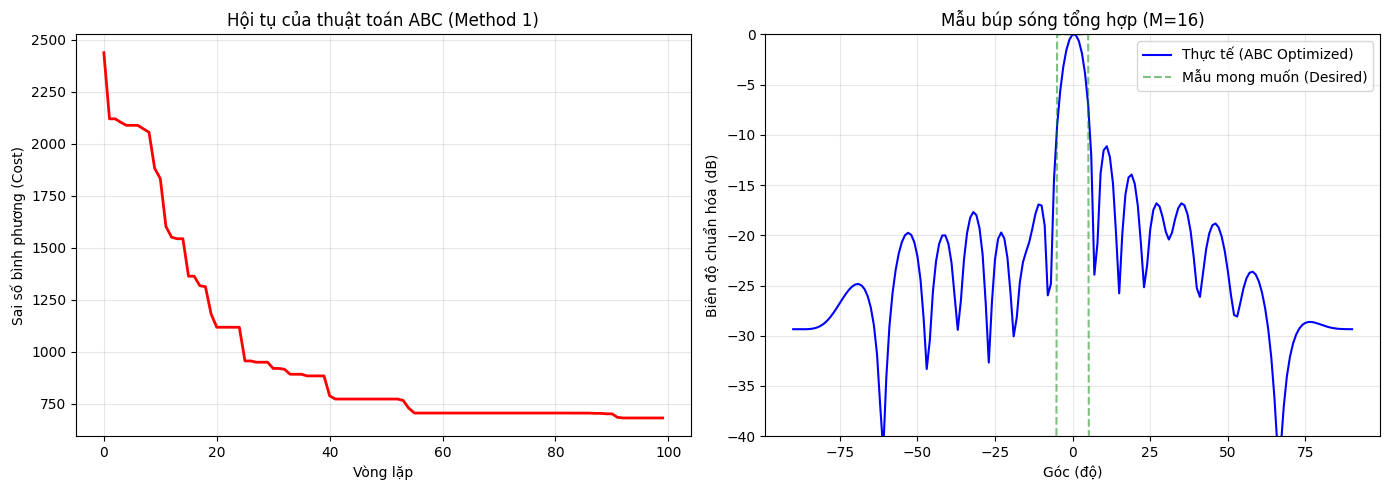

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# =========================
# 1) ULA steering vector
# =========================
def steering_ula(M: int, theta_deg: float) -> np.ndarray:
    """
    a(theta) = [1, e^{j*pi*sin(theta)}, ..., e^{j*pi*(M-1)*sin(theta)}]^T
    """
    theta = np.deg2rad(theta_deg)
    m = np.arange(M)
    return np.exp(1j * np.pi * m * np.sin(theta))

# =========================
# 2) Tạo mẫu búp sóng mong muốn (Desired Pattern)
# =========================
def make_desired_pattern(M: int, target_angle_deg: float = 0.0, num_points: int = 181):
    """
    Tạo mẫu D(theta):
    - Tại hướng target_angle: D = M (Biên độ cực đại)
    - Tại các hướng khác: D = 0 (Triệt tiêu hoàn toàn side-lobes)
    """
    angles = np.linspace(-90, 90, num_points)
    desired = np.zeros(num_points)

    # Tìm chỉ số góc gần với target_angle nhất
    idx = np.argmin(np.abs(angles - target_angle_deg))

    # Thiết lập độ rộng búp sóng chính (Main lobe width)
    # Ví dụ: +/- 5 độ quanh đỉnh là búp chính
    width = 5
    for i in range(max(0, idx - width), min(num_points, idx + width + 1)):
         desired[i] = M # Mức biên độ mong muốn cao nhất

    return angles, desired

# =========================
# 3) Hàm mục tiêu: Method 1 (Pattern Synthesis)
# =========================
def objective_pattern_synthesis(phases, M, angles, desired_pattern):
    """
    Hàm mục tiêu tính sai số (Error) cần cực tiểu hóa.
    f(w) = Sum | |w^H * a(theta)| - D(theta) |^2

    Input:
    - phases: Vector chứa M góc pha [theta_1, ..., theta_M]
    """
    # Tạo vector trọng số w từ pha (Ràng buộc biên độ không đổi = 1)
    w = np.exp(1j * phases)

    # Tính sai số tổng
    total_error = 0

    # Duyệt qua từng góc khảo sát
    for i, ang in enumerate(angles):
        a_vec = steering_ula(M, ang)
        # Biên độ thực tế: |w^H * a|
        actual_mag = np.abs(np.vdot(w, a_vec))

        # Sai số bình phương
        diff = actual_mag - desired_pattern[i]
        total_error += diff**2

    return total_error

# =========================
# 4) ABC Vector Optimization (Đa biến)
# =========================
def abc_pattern_synthesis(
    M, angles, desired_pattern,
    colony_size=50,
    cycles=100,
    limit=20,
    seed=42
):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M # Số chiều bài toán = Số lượng anten

    # Khởi tạo quần thể: Ma trận [SN x M]
    # Mỗi hàng là một vector chứa M góc pha
    pop = rng.uniform(-np.pi, np.pi, (SN, D))

    # Tính Cost (Sai số) cho từng cá thể
    # Lưu ý: ABC gốc tìm Max, nhưng bài này tìm Min Error.
    # Ta dùng fitness = 1 / (1 + Error) để chuyển về bài toán Max.
    cost = np.array([objective_pattern_synthesis(ind, M, angles, desired_pattern) for ind in pop])
    fitness = 1.0 / (1.0 + cost)

    trial = np.zeros(SN, dtype=int)
    best_curve = np.zeros(cycles) # Lưu lại Error nhỏ nhất mỗi vòng

    # Lưu nghiệm tốt nhất toàn cục
    best_idx = np.argmax(fitness)
    gbest_cost = cost[best_idx]
    gbest_sol = pop[best_idx].copy()

    def wrap(x):
        return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # --- Giai đoạn 1: Ong thợ (Employed Bees) ---
        for i in range(SN):
            # Chọn đối tác ngẫu nhiên k != i
            k = i
            while k == i: k = rng.integers(0, SN)

            # Chọn một chiều ngẫu nhiên j để biến đổi
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            # Tạo nghiệm mới v_i
            v = pop[i].copy()
            v[j] = wrap(pop[i, j] + phi * (pop[i, j] - pop[k, j]))

            # Đánh giá
            v_cost = objective_pattern_synthesis(v, M, angles, desired_pattern)
            v_fit = 1.0 / (1.0 + v_cost)

            if v_fit > fitness[i]:
                pop[i] = v
                fitness[i] = v_fit
                cost[i] = v_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Giai đoạn 2: Ong quan sát (Onlooker Bees) ---
        # Tính xác suất chọn lọc
        prob = fitness / np.sum(fitness)

        for _ in range(SN):
            # Chọn nguồn thức ăn i dựa trên xác suất (Roulette Wheel)
            i = rng.choice(SN, p=prob)

            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            v = pop[i].copy()
            v[j] = wrap(pop[i, j] + phi * (pop[i, j] - pop[k, j]))

            v_cost = objective_pattern_synthesis(v, M, angles, desired_pattern)
            v_fit = 1.0 / (1.0 + v_cost)

            if v_fit > fitness[i]:
                pop[i] = v
                fitness[i] = v_fit
                cost[i] = v_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Giai đoạn 3: Ong trinh sát (Scout Bees) ---
        for i in range(SN):
            if trial[i] >= limit:
                pop[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = objective_pattern_synthesis(pop[i], M, angles, desired_pattern)
                fitness[i] = 1.0 / (1.0 + cost[i])
                trial[i] = 0

        # Cập nhật Global Best (Tìm Min Error)
        current_best_idx = np.argmin(cost)
        if cost[current_best_idx] < gbest_cost:
            gbest_cost = cost[current_best_idx]
            gbest_sol = pop[current_best_idx].copy()

        best_curve[t] = gbest_cost
        print(f"Cycle {t+1}/{cycles}: Best Error = {gbest_cost:.4f}")

    return gbest_sol, gbest_cost, best_curve

# =========================
# 5) Main Execution
# =========================
if __name__ == "__main__":
    # Cấu hình
    M = 16          # Số lượng anten
    angles, desired = make_desired_pattern(M, target_angle_deg=0.0)

    print(f"Bắt đầu tối ưu hóa mẫu búp sóng cho {M} anten...")
    best_phases, min_error, curve = abc_pattern_synthesis(
        M, angles, desired,
        colony_size=50,
        cycles=100,
        limit=10,
        seed=42
    )

    # Tạo vector trọng số tối ưu
    w_opt = np.exp(1j * best_phases)

    # --- Vẽ đồ thị kết quả ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Đồ thị hội tụ (Error giảm dần)
    ax1.plot(curve, linewidth=2, color='red')
    ax1.set_title("Hội tụ của thuật toán ABC (Method 1)")
    ax1.set_xlabel("Vòng lặp")
    ax1.set_ylabel("Sai số bình phương (Cost)")
    ax1.grid(True, alpha=0.3)

    # 2. Đồ thị búp sóng (Pattern)
    # Tính mẫu thực tế từ w_opt
    real_pattern = []
    for ang in angles:
        a_vec = steering_ula(M, ang)
        val = np.abs(np.vdot(w_opt, a_vec))
        real_pattern.append(val)

    # Chuyển sang dB để dễ nhìn búp phụ
    real_pattern_db = 20 * np.log10(np.array(real_pattern) / np.max(real_pattern) + 1e-9)
    desired_db = 20 * np.log10(desired / np.max(desired) + 1e-9) # Mẫu cũng chuyển dB

    ax2.plot(angles, real_pattern_db, label="Thực tế (ABC Optimized)", color='blue')
    # Vẽ mẫu mong muốn (chỉ vẽ đường bao)
    ax2.plot(angles, desired_db, '--', label="Mẫu mong muốn (Desired)", color='green', alpha=0.5)

    ax2.set_title(f"Mẫu búp sóng tổng hợp (M={M})")
    ax2.set_xlabel("Góc (độ)")
    ax2.set_ylabel("Biên độ chuẩn hóa (dB)")
    ax2.set_ylim([-40, 0]) # Giới hạn trục y để nhìn rõ side-lobes
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

--- Bắt đầu tối ưu Method 1 cho 16 anten ---
ABC Final Cost: 1062.6961
GABC Final Cost: 1053.5749


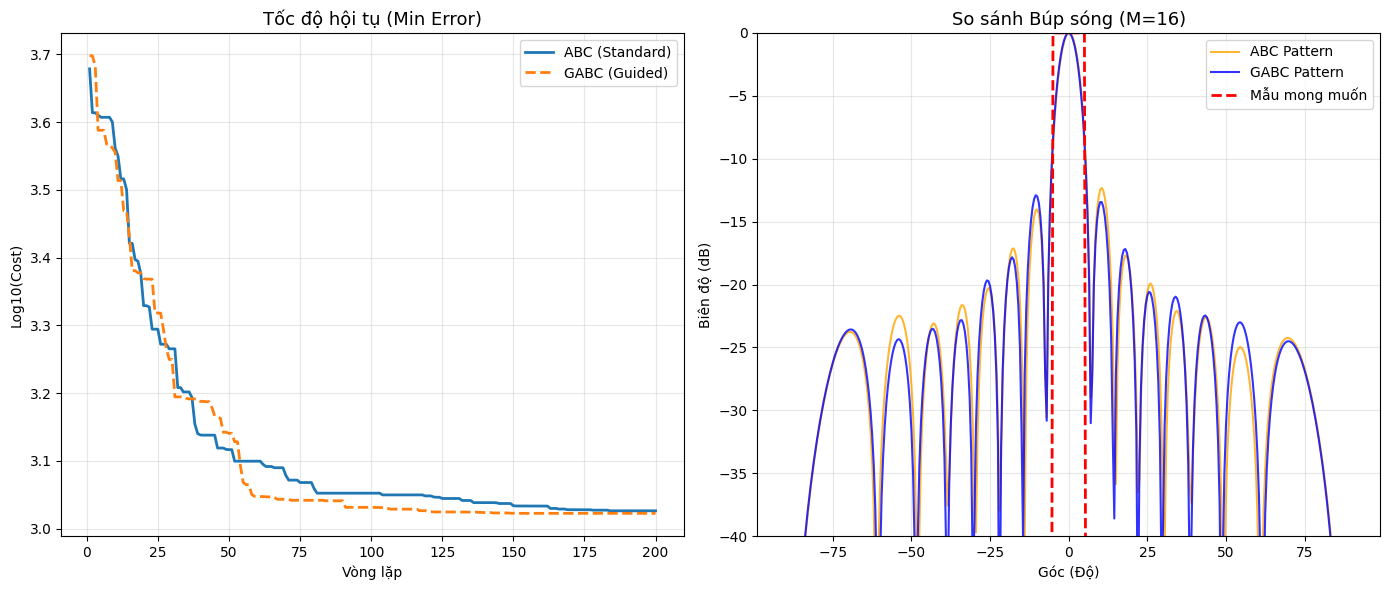

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# =========================
# 1) Cấu hình Hệ thống & Mẫu mong muốn
# =========================
def steering_ula(M: int, theta_deg: float) -> np.ndarray:
    """Vector lái a(theta)"""
    theta = np.deg2rad(theta_deg)
    m = np.arange(M)
    return np.exp(1j * np.pi * m * np.sin(theta))

def get_steering_matrix(M, angles_deg):
    """Tạo ma trận lái A [Số góc x M] để tính toán nhanh"""
    A = np.zeros((len(angles_deg), M), dtype=np.complex128)
    for i, ang in enumerate(angles_deg):
        A[i, :] = steering_ula(M, ang)
    return A

def make_desired_pattern(angles_deg, target_deg=0.0, beam_width=10.0, M=16):
    """
    Tạo mẫu D(theta):
    - Main lobe: Biên độ = M
    - Side lobe: Biên độ = 0
    """
    desired = np.zeros_like(angles_deg)
    mask = np.abs(angles_deg - target_deg) <= (beam_width / 2)
    desired[mask] = M
    return desired

# =========================
# 2) Hàm Mục Tiêu (Method 1)
# =========================
def cost_function(phases, A_mat, desired_pat):
    """
    f(w) = Sum | |w^H * a(theta)| - D(theta) |^2
    """
    w = np.exp(1j * phases)
    generated_pattern = np.abs(A_mat @ w)
    error = np.sum((generated_pattern - desired_pat)**2)
    return error

# =========================
# 3) Thuật toán ABC (Standard)
# =========================
def run_abc_synthesis(M, A_mat, desired, colony_size, cycles, limit, seed):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M

    pop = rng.uniform(-np.pi, np.pi, (SN, D))
    cost = np.array([cost_function(p, A_mat, desired) for p in pop])
    trial = np.zeros(SN, dtype=int)

    best_curve = np.zeros(cycles)
    gbest_cost = np.min(cost)
    gbest_pos = pop[np.argmin(cost)].copy()

    def wrap(x): return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # --- Employed ---
        for i in range(SN):
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)

            phi = rng.uniform(-1, 1)
            new_pos = pop[i].copy()
            new_pos[j] = wrap(pop[i,j] + phi * (pop[i,j] - pop[k,j]))

            new_cost = cost_function(new_pos, A_mat, desired)
            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Onlooker ---
        fitness = 1.0 / (1.0 + cost)
        prob = fitness / np.sum(fitness)
        for _ in range(SN):
            i = rng.choice(SN, p=prob)
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            new_pos = pop[i].copy()
            new_pos[j] = wrap(pop[i,j] + phi * (pop[i,j] - pop[k,j]))
            new_cost = cost_function(new_pos, A_mat, desired)
            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Scout ---
        for i in range(SN):
            if trial[i] >= limit:
                pop[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = cost_function(pop[i], A_mat, desired)
                trial[i] = 0

        if np.min(cost) < gbest_cost:
            gbest_cost = np.min(cost)
            gbest_pos = pop[np.argmin(cost)].copy()
        best_curve[t] = gbest_cost

    return gbest_pos, best_curve

# =========================
# 4) Thuật toán GABC (Gbest-guided)
# =========================
def run_gabc_synthesis(M, A_mat, desired, colony_size, cycles, limit, seed, C=1.5):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M

    pop = rng.uniform(-np.pi, np.pi, (SN, D))
    cost = np.array([cost_function(p, A_mat, desired) for p in pop])
    trial = np.zeros(SN, dtype=int)

    best_curve = np.zeros(cycles)
    gbest_cost = np.min(cost)
    gbest_pos = pop[np.argmin(cost)].copy()

    def wrap(x): return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # --- Employed (G-ABC update) ---
        for i in range(SN):
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            psi = rng.uniform(0, C)

            new_pos = pop[i].copy()
            # GABC equation
            term1 = phi * (pop[i,j] - pop[k,j])
            term2 = psi * (gbest_pos[j] - pop[i,j])
            new_pos[j] = wrap(pop[i,j] + term1 + term2)

            new_cost = cost_function(new_pos, A_mat, desired)
            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Onlooker (G-ABC update) ---
        fitness = 1.0 / (1.0 + cost)
        prob = fitness / np.sum(fitness)
        for _ in range(SN):
            i = rng.choice(SN, p=prob)
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            psi = rng.uniform(0, C)
            new_pos = pop[i].copy()
            term1 = phi * (pop[i,j] - pop[k,j])
            term2 = psi * (gbest_pos[j] - pop[i,j])
            new_pos[j] = wrap(pop[i,j] + term1 + term2)
            new_cost = cost_function(new_pos, A_mat, desired)
            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Scout ---
        for i in range(SN):
            if trial[i] >= limit:
                pop[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = cost_function(pop[i], A_mat, desired)
                trial[i] = 0

        if np.min(cost) < gbest_cost:
            gbest_cost = np.min(cost)
            gbest_pos = pop[np.argmin(cost)].copy()
        best_curve[t] = gbest_cost

    return gbest_pos, best_curve

# =========================
# 5) Main & Plot Comparison
# =========================
if __name__ == "__main__":
    M = 16
    colony_size = 50
    cycles = 200
    limit = 20
    seed = 42

    angles_deg = np.linspace(-90, 90, 361)
    desired = make_desired_pattern(angles_deg, target_deg=0.0, beam_width=10, M=M)
    A_mat = get_steering_matrix(M, angles_deg)

    print(f"--- Bắt đầu tối ưu Method 1 cho {M} anten ---")

    # 1. Chạy ABC
    w_phases_abc, curve_abc = run_abc_synthesis(M, A_mat, desired, colony_size, cycles, limit, seed)
    print(f"ABC Final Cost: {curve_abc[-1]:.4f}")

    # 2. Chạy GABC
    w_phases_gabc, curve_gabc = run_gabc_synthesis(M, A_mat, desired, colony_size, cycles, limit, seed, C=1.5)
    print(f"GABC Final Cost: {curve_gabc[-1]:.4f}")

    # --- Tính toán Pattern từ kết quả tối ưu ---
    # ABC Pattern
    w_abc = np.exp(1j * w_phases_abc)
    pat_abc = np.abs(A_mat @ w_abc)
    pat_abc_db = 20 * np.log10(pat_abc / np.max(pat_abc) + 1e-9)

    # GABC Pattern
    w_gabc = np.exp(1j * w_phases_gabc)
    pat_gabc = np.abs(A_mat @ w_gabc)
    pat_gabc_db = 20 * np.log10(pat_gabc / np.max(pat_gabc) + 1e-9)

    # Desired Pattern (để so sánh)
    pat_des_db = 20 * np.log10(desired / np.max(desired) + 1e-9)
    pat_des_db[pat_des_db < -60] = -60

    # --- Vẽ 2 hình ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Hình 1: Tốc độ hội tụ
    x = np.arange(1, cycles + 1)
    ax1.plot(x, np.log10(curve_abc), linewidth=2, label="ABC (Standard)")
    ax1.plot(x, np.log10(curve_gabc), linewidth=2, linestyle="--", label="GABC (Guided)")
    ax1.set_title("Tốc độ hội tụ (Min Error)", fontsize=13)
    ax1.set_xlabel("Vòng lặp")
    ax1.set_ylabel("Log10(Cost)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Hình 2: So sánh Búp sóng (ABC vs GABC)
    ax2.plot(angles_deg, pat_abc_db, linewidth=1.5, label="ABC Pattern", color='orange', alpha=0.8)
    ax2.plot(angles_deg, pat_gabc_db, linewidth=1.5, label="GABC Pattern", color='blue', alpha=0.8)
    ax2.plot(angles_deg, pat_des_db, '--', linewidth=2, label="Mẫu mong muốn", color='red')

    ax2.set_title(f"So sánh Búp sóng (M={M})", fontsize=13)
    ax2.set_xlabel("Góc (Độ)")
    ax2.set_ylabel("Biên độ (dB)")
    ax2.set_ylim([-40, 0])
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

--- Bắt đầu bài toán KHÓ (Hard Mode) ---
Anten: 24, Target: 15.0 deg
Nulls tại: [-40, -20, 35] (Yêu cầu triệt tiêu mạnh)
ABC Final Weighted Cost: 5231.5707
ILS Final Weighted Cost: 5326.9773


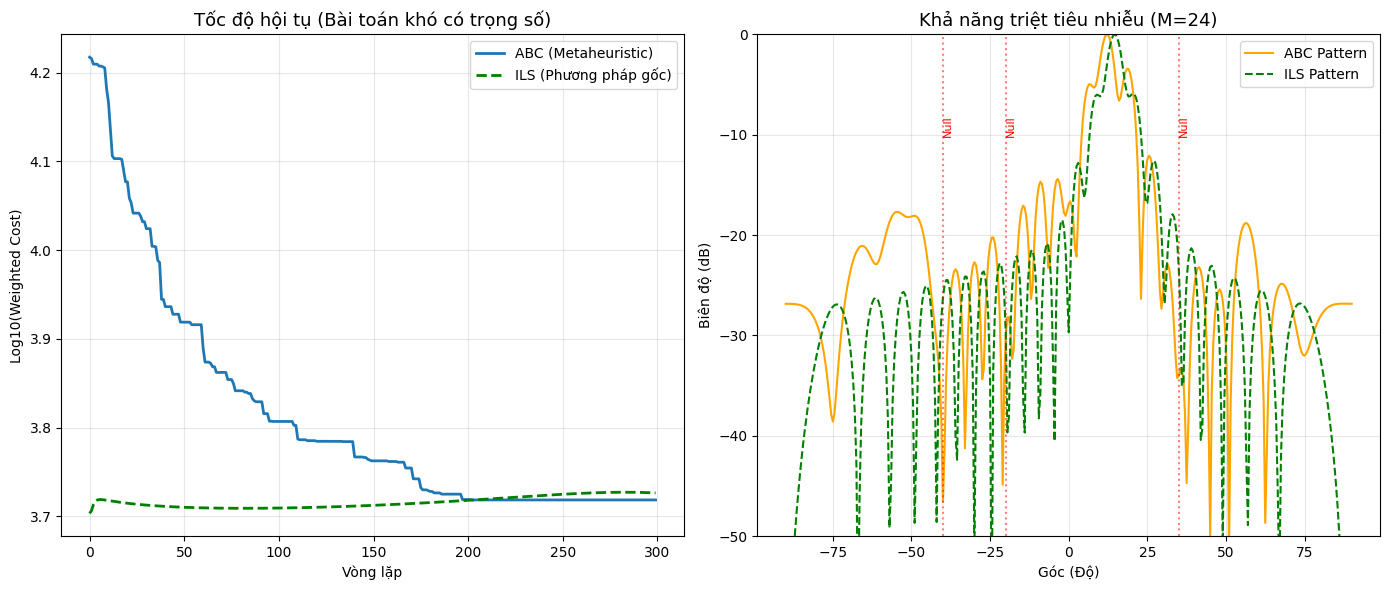

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# =========================
# 1) Cấu hình Hệ thống
# =========================
def steering_ula(M: int, theta_deg: float) -> np.ndarray:
    theta = np.deg2rad(theta_deg)
    m = np.arange(M)
    return np.exp(1j * np.pi * m * np.sin(theta))

def get_steering_matrix(M, angles_deg):
    A = np.zeros((len(angles_deg), M), dtype=np.complex128)
    for i, ang in enumerate(angles_deg):
        A[i, :] = steering_ula(M, ang)
    return A

# =========================
# 2) TẠO MẪU KHÓ (Hard Desired Pattern)
# =========================
def make_hard_pattern(angles_deg, target_deg=10.0, nulls=[-30, -10, 40], M=24):
    """
    Tạo mẫu D(theta) khó hơn:
    1. Búp chính lệch tâm (tại target_deg)
    2. Yêu cầu triệt tiêu (Nulls) tại các góc cụ thể
    """
    desired = np.zeros_like(angles_deg)

    # 1. Main lobe (Búp chính)
    beam_width = 8.0 # Hẹp hơn để khó hơn
    mask_main = np.abs(angles_deg - target_deg) <= (beam_width / 2)
    desired[mask_main] = M

    # 2. Side lobes (Búp phụ)
    # Mặc định là 0 (muốn triệt tiêu hết mức có thể)
    # Nhưng ta sẽ tạo một "trọng số" (Weight) để phạt nặng các điểm Null

    return desired

def cost_function_weighted(w_complex, A_mat, desired_pat, weights):
    """
    Hàm mục tiêu có trọng số (Weighted Least Squares)
    Để ép thuật toán phải triệt tiêu nhiễu tại các vùng Null
    """
    generated_pattern = np.abs(A_mat @ w_complex)
    # Sai số bình phương có trọng số
    error = np.sum(weights * (generated_pattern - desired_pat)**2)
    return error

# =========================
# 3) Thuật toán ABC (Method 1)
# =========================
def run_abc_synthesis(M, A_mat, desired, weights, colony_size, cycles, limit, seed):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M

    pop_phases = rng.uniform(-np.pi, np.pi, (SN, D))

    def get_cost(phases):
        w = np.exp(1j * phases)
        return cost_function_weighted(w, A_mat, desired, weights)

    cost = np.array([get_cost(p) for p in pop_phases])
    trial = np.zeros(SN, dtype=int)

    best_curve = np.zeros(cycles)
    gbest_cost = np.min(cost)
    gbest_pos = pop_phases[np.argmin(cost)].copy()

    def wrap(x): return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # Employed
        for i in range(SN):
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            new_pos = pop_phases[i].copy()
            new_pos[j] = wrap(pop_phases[i,j] + phi * (pop_phases[i,j] - pop_phases[k,j]))

            new_cost = get_cost(new_pos)
            if new_cost < cost[i]:
                pop_phases[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker
        fitness = 1.0 / (1.0 + cost)
        prob = fitness / np.sum(fitness)
        for _ in range(SN):
            i = rng.choice(SN, p=prob)
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            new_pos = pop_phases[i].copy()
            new_pos[j] = wrap(pop_phases[i,j] + phi * (pop_phases[i,j] - pop_phases[k,j]))
            new_cost = get_cost(new_pos)
            if new_cost < cost[i]:
                pop_phases[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout
        for i in range(SN):
            if trial[i] >= limit:
                pop_phases[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = get_cost(pop_phases[i])
                trial[i] = 0

        if np.min(cost) < gbest_cost:
            gbest_cost = np.min(cost)
            gbest_pos = pop_phases[np.argmin(cost)].copy()

        best_curve[t] = gbest_cost

    return gbest_pos, best_curve

# =========================
# 4) Thuật toán ILS (Gốc) - Có thêm trọng số
# =========================
def run_ils_synthesis_weighted(M, A_mat, desired, weights, cycles, seed):
    """
    Weighted Iterative Least Squares (W-ILS)
    """
    rng = np.random.default_rng(seed)
    phases = rng.uniform(-np.pi, np.pi, M)
    w = np.exp(1j * phases)

    # Weighted Pseudo-inverse (Phức tạp hơn chút để công bằng)
    # W_mat = diag(sqrt(weights))
    # A_w = W_mat @ A
    # Nhưng để mô phỏng ILS gốc (thường không dùng trọng số trong bước nghịch đảo),
    # ta dùng ILS tiêu chuẩn nhưng đánh giá bằng hàm cost có trọng số.
    # ILS tiêu chuẩn thường hội tụ về búp chính mạnh nhưng lờ đi các Null sâu.

    A_pinv = np.linalg.pinv(A_mat)

    cost_curve = np.zeros(cycles)

    for t in range(cycles):
        # Forward
        y = A_mat @ w

        # Target update: Giữ pha, ép biên độ
        y_target = desired * np.exp(1j * np.angle(y))

        # Backward (Least Squares update)
        w_new = A_pinv @ y_target

        # Constraint (Constant Modulus)
        w = np.exp(1j * np.angle(w_new))

        cost_curve[t] = cost_function_weighted(w, A_mat, desired, weights)

    return w, cost_curve

# =========================
# 5) Main Comparison
# =========================
if __name__ == "__main__":
    # --- TĂNG ĐỘ KHÓ ---
    M = 24              # Tăng số anten (Khó hơn)
    target_deg = 15.0   # Búp chính lệch tâm
    null_angles = [-40, -20, 35] # Yêu cầu 3 điểm chết cụ thể

    colony_size = 80
    cycles = 300        # Cần nhiều vòng hơn để giải bài khó
    limit = 30
    seed = 99           # Chọn seed để thấy rõ sự khác biệt

    # Setup không gian
    angles_deg = np.linspace(-90, 90, 361)
    A_mat = get_steering_matrix(M, angles_deg)

    # 1. Tạo mẫu mong muốn
    desired = make_desired_pattern(angles_deg, target_deg=target_deg, M=M)

    # 2. Tạo trọng số phạt (Weights)
    # Mặc định = 1. Tại các điểm Nulls, phạt nặng (Weight = 100)
    weights = np.ones_like(angles_deg)
    for null_ang in null_angles:
        # Tìm index gần góc null nhất
        idx = np.argmin(np.abs(angles_deg - null_ang))
        # Phạt vùng +/- 2 độ quanh null
        weights[idx-2:idx+3] = 50.0

    print(f"--- Bắt đầu bài toán KHÓ (Hard Mode) ---")
    print(f"Anten: {M}, Target: {target_deg} deg")
    print(f"Nulls tại: {null_angles} (Yêu cầu triệt tiêu mạnh)")

    # 1. Chạy ABC
    phases_abc, curve_abc = run_abc_synthesis(M, A_mat, desired, weights, colony_size, cycles, limit, seed)
    w_final_abc = np.exp(1j * phases_abc)
    print(f"ABC Final Weighted Cost: {curve_abc[-1]:.4f}")

    # 2. Chạy ILS
    w_final_ils, curve_ils = run_ils_synthesis_weighted(M, A_mat, desired, weights, cycles, seed)
    print(f"ILS Final Weighted Cost: {curve_ils[-1]:.4f}")

    # --- Plotting ---
    # Tính Pattern dB
    pat_abc = np.abs(A_mat @ w_final_abc)
    pat_abc_db = 20 * np.log10(pat_abc / np.max(pat_abc) + 1e-9)

    pat_ils = np.abs(A_mat @ w_final_ils)
    pat_ils_db = 20 * np.log10(pat_ils / np.max(pat_ils) + 1e-9)

    pat_des_db = 20 * np.log10(desired / np.max(desired) + 1e-9)
    pat_des_db[pat_des_db < -60] = -60

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Hình 1: Hội tụ Cost (Weighted)
    ax1.plot(np.log10(curve_abc), linewidth=2, label="ABC (Metaheuristic)")
    ax1.plot(np.log10(curve_ils), linewidth=2, linestyle="--", color='green', label="ILS (Phương pháp gốc)")
    ax1.set_title("Tốc độ hội tụ (Bài toán khó có trọng số)", fontsize=13)
    ax1.set_xlabel("Vòng lặp")
    ax1.set_ylabel("Log10(Weighted Cost)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Hình 2: Búp sóng
    ax2.plot(angles_deg, pat_abc_db, linewidth=1.5, label="ABC Pattern", color='orange')
    ax2.plot(angles_deg, pat_ils_db, linewidth=1.5, linestyle='--', label="ILS Pattern", color='green')

    # Vẽ các đường đánh dấu vị trí Null mong muốn
    for null_ang in null_angles:
        ax2.axvline(x=null_ang, color='red', linestyle=':', alpha=0.5)
        ax2.text(null_ang, -10, 'Null', color='red', fontsize=8, rotation=90)

    ax2.set_title(f"Khả năng triệt tiêu nhiễu (M={M})", fontsize=13)
    ax2.set_xlabel("Góc (Độ)")
    ax2.set_ylabel("Biên độ (dB)")
    ax2.set_ylim([-50, 0])
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

--- HARD MODE ---
Anten: 24, Target: 15.0 deg
Nulls: [-40, -20, 35]
ABC Final Cost: 2.8814e+03
ILS Final Cost: 3.0724e+03


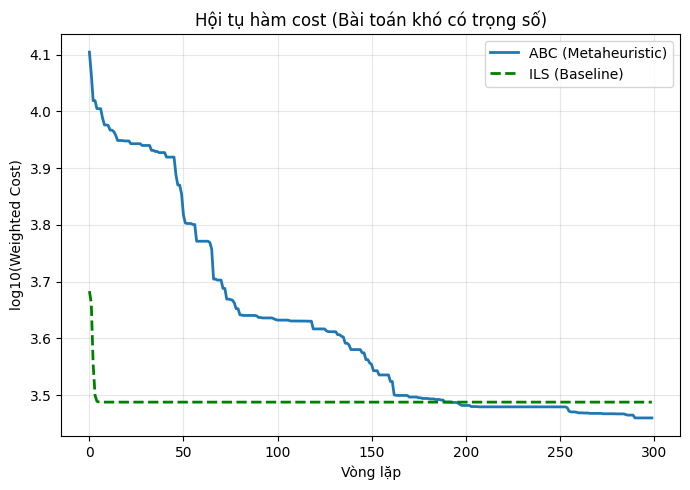

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# =========================
# 1) Cấu hình Hệ thống
# =========================
def steering_ula(M: int, theta_deg: float) -> np.ndarray:
    theta = np.deg2rad(theta_deg)
    m = np.arange(M)
    return np.exp(1j * np.pi * m * np.sin(theta))

def get_steering_matrix(M, angles_deg):
    A = np.zeros((len(angles_deg), M), dtype=np.complex128)
    for i, ang in enumerate(angles_deg):
        A[i, :] = steering_ula(M, ang)
    return A

# =========================
# 2) TẠO MẪU KHÓ (Hard Desired Pattern)
# =========================
def make_hard_pattern(angles_deg, target_deg=10.0, nulls=[-30, -10, 40], M=24):
    """
    Tạo mẫu D(theta) khó hơn:
    1. Búp chính lệch tâm (tại target_deg)
    2. Yêu cầu triệt tiêu (Nulls) tại các góc cụ thể
    """
    desired = np.zeros_like(angles_deg)

    # 1. Main lobe
    beam_width = 8.0
    mask_main = np.abs(angles_deg - target_deg) <= (beam_width / 2)
    desired[mask_main] = M

    return desired

def cost_function_weighted(w_complex, A_mat, desired_pat, weights):
    """
    Weighted Least Squares cost
    """
    generated_pattern = np.abs(A_mat @ w_complex)
    error = np.sum(weights * (generated_pattern - desired_pat)**2)
    return error

# =========================
# 3) Thuật toán ABC
# =========================
def run_abc_synthesis(M, A_mat, desired, weights, colony_size, cycles, limit, seed):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M

    pop_phases = rng.uniform(-np.pi, np.pi, (SN, D))

    def get_cost(phases):
        w = np.exp(1j * phases)
        return cost_function_weighted(w, A_mat, desired, weights)

    cost = np.array([get_cost(p) for p in pop_phases])
    trial = np.zeros(SN, dtype=int)

    best_curve = np.zeros(cycles)
    gbest_cost = np.min(cost)
    gbest_pos = pop_phases[np.argmin(cost)].copy()

    def wrap(x): return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # Employed bees
        for i in range(SN):
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            new_pos = pop_phases[i].copy()
            new_pos[j] = wrap(pop_phases[i,j] + phi * (pop_phases[i,j] - pop_phases[k,j]))

            new_cost = get_cost(new_pos)
            if new_cost < cost[i]:
                pop_phases[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker bees
        fitness = 1.0 / (1.0 + cost)
        prob = fitness / np.sum(fitness)
        for _ in range(SN):
            i = rng.choice(SN, p=prob)
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            new_pos = pop_phases[i].copy()
            new_pos[j] = wrap(pop_phases[i,j] + phi * (pop_phases[i,j] - pop_phases[k,j]))
            new_cost = get_cost(new_pos)
            if new_cost < cost[i]:
                pop_phases[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout bees
        for i in range(SN):
            if trial[i] >= limit:
                pop_phases[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = get_cost(pop_phases[i])
                trial[i] = 0

        if np.min(cost) < gbest_cost:
            gbest_cost = np.min(cost)
            gbest_pos = pop_phases[np.argmin(cost)].copy()

        best_curve[t] = gbest_cost

    return gbest_pos, best_curve

# =========================
# 4) Thuật toán ILS (Weighted)
# =========================
def run_ils_synthesis_weighted(M, A_mat, desired, weights, cycles, seed):
    rng = np.random.default_rng(seed)
    phases = rng.uniform(-np.pi, np.pi, M)
    w = np.exp(1j * phases)

    A_pinv = np.linalg.pinv(A_mat)
    cost_curve = np.zeros(cycles)

    for t in range(cycles):
        y = A_mat @ w
        y_target = desired * np.exp(1j * np.angle(y))
        w_new = A_pinv @ y_target
        w = np.exp(1j * np.angle(w_new))
        cost_curve[t] = cost_function_weighted(w, A_mat, desired, weights)

    return w, cost_curve

# =========================
# 5) Main (ONLY COST CONVERGENCE)
# =========================
if __name__ == "__main__":
    M = 24
    target_deg = 15.0
    null_angles = [-40, -20, 35]

    colony_size = 80
    cycles = 300
    limit = 30
    seed = 99

    angles_deg = np.linspace(-90, 90, 361)
    A_mat = get_steering_matrix(M, angles_deg)

    desired = make_hard_pattern(angles_deg, target_deg=target_deg, M=M)

    weights = np.ones_like(angles_deg)
    for null_ang in null_angles:
        idx = np.argmin(np.abs(angles_deg - null_ang))
        weights[idx-2:idx+3] = 50.0

    print(f"--- HARD MODE ---")
    print(f"Anten: {M}, Target: {target_deg} deg")
    print(f"Nulls: {null_angles}")

    phases_abc, curve_abc = run_abc_synthesis(
        M, A_mat, desired, weights,
        colony_size, cycles, limit, seed
    )
    print(f"ABC Final Cost: {curve_abc[-1]:.4e}")

    w_ils, curve_ils = run_ils_synthesis_weighted(
        M, A_mat, desired, weights,
        cycles, seed
    )
    print(f"ILS Final Cost: {curve_ils[-1]:.4e}")

    # Plot ONLY convergence
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(np.log10(curve_abc), linewidth=2, label="ABC (Metaheuristic)")
    ax.plot(np.log10(curve_ils), linewidth=2, linestyle="--",
            color='green', label="ILS (Baseline)")

    ax.set_title("Hội tụ hàm cost (Bài toán khó có trọng số)")
    ax.set_xlabel("Vòng lặp")
    ax.set_ylabel("log10(Weighted Cost)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()


--- So sánh ABC vs GABC (Hard Mode: M=24) ---
Nulls tại: [-40, -20, 45]
ABC Final Cost: 7314.0868
GABC Final Cost: 6725.4977


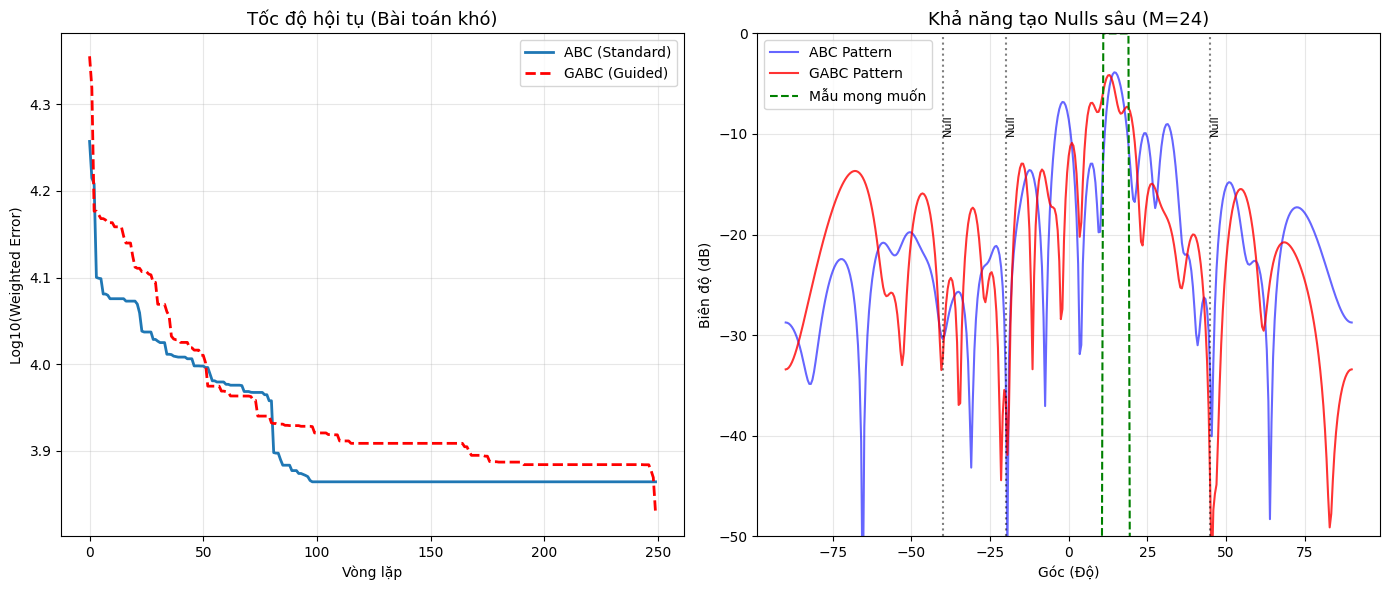

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# =========================
# 1) Cấu hình Hệ thống & Mẫu mong muốn
# =========================
def steering_ula(M: int, theta_deg: float) -> np.ndarray:
    theta = np.deg2rad(theta_deg)
    m = np.arange(M)
    return np.exp(1j * np.pi * m * np.sin(theta))

def get_steering_matrix(M, angles_deg):
    A = np.zeros((len(angles_deg), M), dtype=np.complex128)
    for i, ang in enumerate(angles_deg):
        A[i, :] = steering_ula(M, ang)
    return A

def make_hard_pattern(angles_deg, target_deg, beam_width, M):
    """Tạo mẫu búp sóng mong muốn"""
    desired = np.zeros_like(angles_deg)
    mask_main = np.abs(angles_deg - target_deg) <= (beam_width / 2)
    desired[mask_main] = M
    return desired

def cost_function_weighted(w_complex, A_mat, desired_pat, weights):
    """Hàm mục tiêu có trọng số (Weighted Least Squares)"""
    generated_pattern = np.abs(A_mat @ w_complex)
    error = np.sum(weights * (generated_pattern - desired_pat)**2)
    return error

# =========================
# 2) Thuật toán ABC (Standard) - Weighted
# =========================
def run_abc_weighted(M, A_mat, desired, weights, colony_size, cycles, limit, seed):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M

    pop = rng.uniform(-np.pi, np.pi, (SN, D))

    def get_cost(p):
        return cost_function_weighted(np.exp(1j * p), A_mat, desired, weights)

    cost = np.array([get_cost(p) for p in pop])
    trial = np.zeros(SN, dtype=int)

    best_curve = np.zeros(cycles)
    gbest_cost = np.min(cost)
    gbest_pos = pop[np.argmin(cost)].copy()

    def wrap(x): return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # Employed
        for i in range(SN):
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            new_pos = pop[i].copy()
            new_pos[j] = wrap(pop[i,j] + phi * (pop[i,j] - pop[k,j]))
            new_cost = get_cost(new_pos)

            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker
        fitness = 1.0 / (1.0 + cost)
        prob = fitness / np.sum(fitness)
        for _ in range(SN):
            i = rng.choice(SN, p=prob)
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            new_pos = pop[i].copy()
            new_pos[j] = wrap(pop[i,j] + phi * (pop[i,j] - pop[k,j]))
            new_cost = get_cost(new_pos)

            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout
        for i in range(SN):
            if trial[i] >= limit:
                pop[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = get_cost(pop[i])
                trial[i] = 0

        # Update Global Best
        curr_min = np.min(cost)
        if curr_min < gbest_cost:
            gbest_cost = curr_min
            gbest_pos = pop[np.argmin(cost)].copy()

        best_curve[t] = gbest_cost

    return gbest_pos, best_curve

# =========================
# 3) Thuật toán GABC (Guided) - Weighted
# =========================
def run_gabc_weighted(M, A_mat, desired, weights, colony_size, cycles, limit, seed, C=1.5):
    rng = np.random.default_rng(seed)
    SN = colony_size
    D = M

    pop = rng.uniform(-np.pi, np.pi, (SN, D))

    def get_cost(p):
        return cost_function_weighted(np.exp(1j * p), A_mat, desired, weights)

    cost = np.array([get_cost(p) for p in pop])
    trial = np.zeros(SN, dtype=int)

    best_curve = np.zeros(cycles)
    gbest_cost = np.min(cost)
    gbest_pos = pop[np.argmin(cost)].copy()

    def wrap(x): return np.angle(np.exp(1j * x))

    for t in range(cycles):
        # Employed (GABC Equation)
        for i in range(SN):
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            psi = rng.uniform(0, C) # Hệ số dẫn đường

            new_pos = pop[i].copy()
            # v_ij = x_ij + phi*(x_ij - x_kj) + psi*(gbest_j - x_ij)
            term1 = phi * (pop[i,j] - pop[k,j])
            term2 = psi * (gbest_pos[j] - pop[i,j])
            new_pos[j] = wrap(pop[i,j] + term1 + term2)

            new_cost = get_cost(new_pos)
            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker (GABC Equation)
        fitness = 1.0 / (1.0 + cost)
        prob = fitness / np.sum(fitness)
        for _ in range(SN):
            i = rng.choice(SN, p=prob)
            k = i
            while k == i: k = rng.integers(0, SN)
            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)
            psi = rng.uniform(0, C)

            new_pos = pop[i].copy()
            term1 = phi * (pop[i,j] - pop[k,j])
            term2 = psi * (gbest_pos[j] - pop[i,j])
            new_pos[j] = wrap(pop[i,j] + term1 + term2)

            new_cost = get_cost(new_pos)
            if new_cost < cost[i]:
                pop[i] = new_pos
                cost[i] = new_cost
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout
        for i in range(SN):
            if trial[i] >= limit:
                pop[i] = rng.uniform(-np.pi, np.pi, D)
                cost[i] = get_cost(pop[i])
                trial[i] = 0

        # Update Global Best
        curr_min = np.min(cost)
        if curr_min < gbest_cost:
            gbest_cost = curr_min
            gbest_pos = pop[np.argmin(cost)].copy()

        best_curve[t] = gbest_cost

    return gbest_pos, best_curve

# =========================
# 4) Main Comparison
# =========================
if __name__ == "__main__":
    # --- CẤU HÌNH ĐỘ KHÓ CAO ---
    M = 24               # Số anten lớn -> Không gian tìm kiếm 24 chiều
    target_deg = 15.0    # Búp chính lệch tâm
    null_angles = [-40, -20, 45] # 3 điểm cần triệt tiêu nhiễu sâu

    colony_size = 50
    cycles = 250         # Số vòng lặp
    limit = 20
    seed = 10            # Seed cố định để so sánh công bằng

    # 1. Setup không gian góc
    angles_deg = np.linspace(-90, 90, 361)
    A_mat = get_steering_matrix(M, angles_deg)

    # 2. Tạo mẫu mong muốn
    desired = make_hard_pattern(angles_deg, target_deg, beam_width=8.0, M=M)

    # 3. Tạo trọng số phạt (Weights)
    weights = np.ones_like(angles_deg)
    for null_ang in null_angles:
        # Phạt nặng xung quanh các điểm Null (+/- 2 độ)
        idx = np.argmin(np.abs(angles_deg - null_ang))
        weights[idx-2:idx+3] = 100.0

    print(f"--- So sánh ABC vs GABC (Hard Mode: M={M}) ---")
    print(f"Nulls tại: {null_angles}")

    # --- Chạy ABC ---
    phases_abc, curve_abc = run_abc_weighted(M, A_mat, desired, weights, colony_size, cycles, limit, seed)
    print(f"ABC Final Cost: {curve_abc[-1]:.4f}")

    # --- Chạy GABC ---
    phases_gabc, curve_gabc = run_gabc_weighted(M, A_mat, desired, weights, colony_size, cycles, limit, seed, C=1.5)
    print(f"GABC Final Cost: {curve_gabc[-1]:.4f}")

    # --- Tính toán Pattern kết quả ---
    w_abc = np.exp(1j * phases_abc)
    pat_abc = 20 * np.log10(np.abs(A_mat @ w_abc) / M + 1e-9)

    w_gabc = np.exp(1j * phases_gabc)
    pat_gabc = 20 * np.log10(np.abs(A_mat @ w_gabc) / M + 1e-9)

    pat_des = 20 * np.log10(desired / M + 1e-9)
    pat_des[pat_des < -60] = -60

    # --- Vẽ Đồ thị ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Hình 1: Tốc độ hội tụ
    x = np.arange(1, cycles + 1)
    ax1.plot(np.log10(curve_abc), linewidth=2, label="ABC (Standard)")
    ax1.plot(np.log10(curve_gabc), linewidth=2, linestyle="--", color='red', label="GABC (Guided)")
    ax1.set_title("Tốc độ hội tụ (Bài toán khó)", fontsize=13)
    ax1.set_xlabel("Vòng lặp")
    ax1.set_ylabel("Log10(Weighted Error)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Hình 2: Búp sóng kết quả
    ax2.plot(angles_deg, pat_abc_db := pat_abc, linewidth=1.5, label="ABC Pattern", color='blue', alpha=0.6)
    ax2.plot(angles_deg, pat_gabc_db := pat_gabc, linewidth=1.5, label="GABC Pattern", color='red', alpha=0.8)
    ax2.plot(angles_deg, pat_des, '--', linewidth=1.5, label="Mẫu mong muốn", color='green')

    # Đánh dấu các Null
    for null_ang in null_angles:
        ax2.axvline(x=null_ang, color='black', linestyle=':', alpha=0.5)
        ax2.text(null_ang, -10, 'Null', rotation=90, fontsize=8)

    ax2.set_title(f"Khả năng tạo Nulls sâu (M={M})", fontsize=13)
    ax2.set_xlabel("Góc (Độ)")
    ax2.set_ylabel("Biên độ (dB)")
    ax2.set_ylim([-50, 0])
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()